# 5. Debugging MCMC

In the last notebook 'posterior-functions', we reached the point of running MCMC but quickly ran in to the difficulty potentially caused by not having a likelihood function that accurately reflects likelihood. So we are here going to systematically study that, and potential solutions.

Steps:

- Import specific patient data
- find the simulated annealling parameters for that patient
- directly compare the model and data for all regions just to have a look
- Attempt MCMC using the pearson cost function, starting at the simulated annealling position. 
- now, can we design a better cost function?

In [1]:
import sys, os
sys.path.append("..")

from inverse import bayesian_funcs as bf
from inverse import priors as pr
from preprocess import preprocess as pp
from preprocess import permute
from brain import Brain
from utils import path as pth
from utils import functions

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
from scipy.io import loadmat
import numpy as np
from scipy import stats
import math
import pandas as pd

## Finding a set of parameters with corresponding patient identifier.

In [2]:
HCP_params_path = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/SCFC_opparam_HCP.mat'
HCPdata = loadmat(HCP_params_path)

In [3]:
df = pd.DataFrame(HCPdata['output'][0])
df2 = df.drop(columns = ['feval','simannealmsg', 'cfevals'])

In [4]:
df2.head()

,subjname,param
0,[8002.101],"[[0.012], [0.005], [0.5], [5.0], [4.0], [1.0],..."
1,[8008.101],"[[0.011934858833523522], [0.007416371455534797..."
2,[8012.101],"[[0.015953676157214023], [0.008954110012403716..."
3,[8027.101],"[[0.016012950820885972], [0.008461467268632639..."
4,[8028.101],"[[0.01565266891377659], [0.0061132652979348796..."


Let's work with the second subject, to make a change from always working with the first in the list. This is patient '8008.101'

In [5]:
param_start = df2.iloc[[1]]

In [6]:
param_start = param_start['param'].values[0]

In [7]:
param_start

array([[1.19348588e-02],
       [7.41637146e-03],
       [9.67023304e-01],
       [1.44790558e+01],
       [3.95527275e+00],
       [1.79503011e+00],
       [8.75783847e-03]])

## Getting the corresponding patient MEG spectrum

In [8]:
FMEG_path = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/data/freqMEGdata.mat' #insert appropriate path here.
label_filepath = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/atlases/OrderingAlphabetical_68ROIs.txt'
data = loadmat(FMEG_path)

In [9]:
data['freqMEGdata'].shape

(1, 39)

In [10]:
data['freqMEGdata'][0][1]

(array([[207.40555223, 112.04169602,  78.68421254, ...,  41.9649025 ,
         36.62201405,  28.79667679],
       [104.81741115, 111.23873788,  98.25091692, ...,  21.61562307,
         13.51546009,   5.91221225],
       [136.37605662, 105.40663604, 126.90454504, ...,  18.85706211,
          8.29085297,   3.71796781],
       ...,
       [249.01677792, 199.19023534, 240.82173539, ...,  17.9340072 ,
         10.85342461,   6.82913285],
       [ 39.6609094 ,  52.78331371,  94.21488461, ...,   9.23975365,
          5.00805492,   3.27270123],
       [ 92.57309715, 134.75379333, 245.78013457, ...,  20.93967675,
         14.36975514,   9.50631562]]), array(['8008.101'], dtype='<U8'))

This is the data corresponding to the correct patient. Let's extract the spectrum.

In [11]:
pat_data = data['freqMEGdata'][0][1][0]

In [12]:
pat_data.shape

(68, 40)

68 brain regions, 40 frequency points each. Let's give each of the brain regions a key (make a dictionary of data) and then order them according to the standard we are using for the brain class (HCP).

In [13]:
pat_dict = pp.add_key_to_matdata(label_filepath, pat_data)
orderfile = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/atlases/HCP_list.h5'
FMEGdownsample = permute.order_dict(pat_dict, orderfile)

## Making the model to match

In [14]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

Make the parameter set 'param_start' in to a dictionary to pass to the model.

In [15]:
tau_e, tau_i, alpha, speed, gei, gii, tauC = param_start

In [16]:
param_start

array([[1.19348588e-02],
       [7.41637146e-03],
       [9.67023304e-01],
       [1.44790558e+01],
       [3.95527275e+00],
       [1.79503011e+00],
       [8.75783847e-03]])

In [17]:
parameters = {'tau_e':tau_e[0],
                       'tau_i':tau_i[0],
                       'alpha':alpha[0],
                       'speed':speed[0],
                       'gei':gei[0],
                       'gii':gii[0],
                       'tauC':tauC[0]
                       }

In [18]:
parameters

{'alpha': 0.9670233044667013,
 'gei': 3.9552727546221096,
 'gii': 1.7950301129315296,
 'speed': 14.479055812222878,
 'tauC': 0.008757838469754533,
 'tau_e': 0.011934858833523522,
 'tau_i': 0.007416371455534797}

In [19]:
from forward import runforward as rf
freq_model, frequency_response, eigenvalues, eigenvectors = rf.run_forward(newbrain, parameters, fvec)

## Inspect model and data

Remember, this was the parameter set that the simulated annealing gave as returning the best fit. 

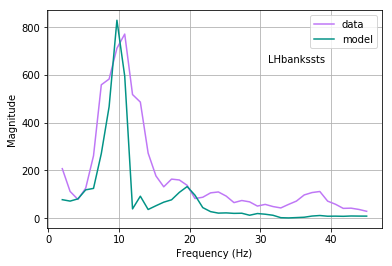

In [20]:
fig = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fvec,FMEGdownsample['LHbankssts'], '-', color= 'xkcd:light purple', label = 'data')
mpl.plot(fvec,70*np.abs(freq_model[0,:]),'-', color= 'xkcd:teal', label = 'model')
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
mpl.text(31,650,'LHbankssts')
ax = mpl.gca()
ax.legend()
fig.savefig("Patient8008_101.pdf", bbox_inches='tight')

Let's plot this quickly for all the regions (automatically finding a scaling factor) and take a look at how well the fit is working for individual regions.

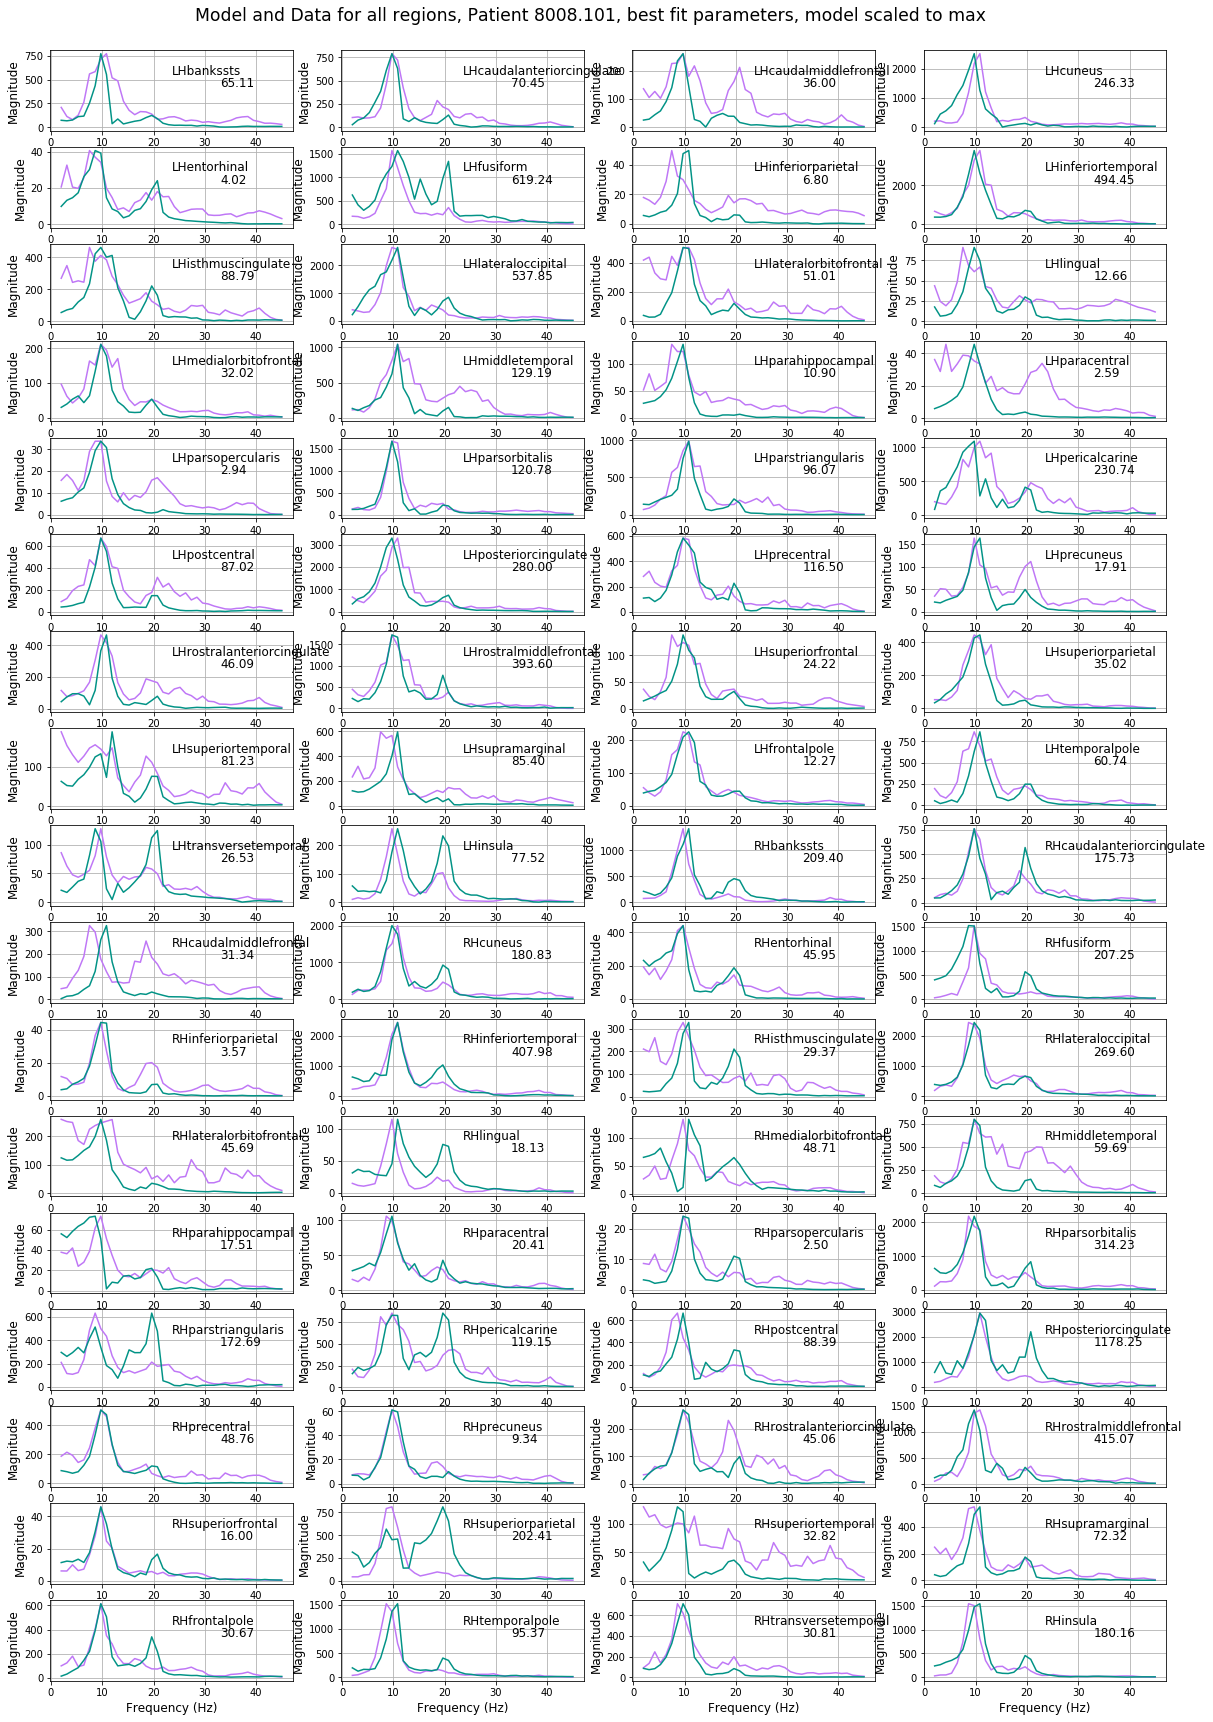

In [21]:
fig1, axes1 = mpl.subplots(17,4, figsize = (20,30))
ax1 = axes1.ravel()
fig1.suptitle('Model and Data for all regions, Patient 8008.101, best fit parameters, model scaled to max', fontsize = 'xx-large', y = 0.9)
i = 0
scale = np.empty(68)

for key in FMEGdownsample.keys():
    mpl.sca(ax1[i])
    mpl.plot(fvec,FMEGdownsample[key], '-', color= 'xkcd:light purple', label = 'data')
    scale[i] = max(FMEGdownsample[key])/max(np.abs(freq_model[i,:]))
    mpl.plot(fvec,scale[i]*np.abs(freq_model[i,:]),'-', color= 'xkcd:teal', label = 'model')
    ax1[i].grid(True)
    ax1[i].set_ylabel('Magnitude', fontsize = 'large')
    ax1[i].text(0.5, 0.7,key,
    transform = ax1[i].transAxes, fontsize = 'large')
    ax1[i].text(0.7, 0.55,"{:.2f}".format(scale[i]),
    transform = ax1[i].transAxes, fontsize = 'large')
    ax1[i].set_xlabel('Frequency (Hz)', fontsize = 'large')
    #ax3[i].axvline(x=param_lower[i], color='r', linestyle='dashed', linewidth=2)
    #ax3[i].axvline(x=param_upper[i], color='r', linestyle='dashed', linewidth=2)
    i += 1
#mpl.sca(ax3[7])
#ax3[7].set_visible(False)
fig1.savefig("Patient8008_101_allregions.pdf", bbox_inches='tight')

OK, now let's take the mean across all regions in both the case of the model and the data. 

In [22]:
FMEGarray = np.empty((68,40))
i = 0
for key in FMEGdownsample.keys():
    FMEGarray[i,:] = FMEGdownsample[key]
    i += 1

In [23]:
FMEGmean = np.mean(FMEGarray, axis = 0)

In [24]:
modelmean = np.mean(freq_model, axis = 0)

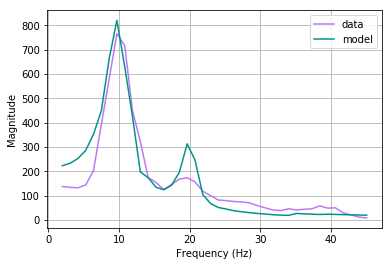

In [25]:
fig2 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fvec,FMEGmean, '-', color= 'xkcd:light purple', label = 'data')
mpl.plot(fvec,700*np.abs(modelmean),'-', color= 'xkcd:teal', label = 'model')
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
#mpl.text(31,650,'LHbankssts')
ax = mpl.gca()
ax.legend()
fig2.savefig("Patient8008_101_means.pdf", bbox_inches='tight')

It looks like the model works well for some regions, but poorly for others, and when the means are compared they look reasonable but not perfect. Let's look at the current pearson r definition of the likelihood function, and it's variation with respect to different parameters.

## Examining the pearson r functions

In [26]:
from scipy.stats import pearsonr
def pearson_cost_oneminus(data, freq_model):
    """pearson_cost_oneminus. A cost function based on the pearson r correlation. Designed to
    be minimised in a fitting process. Uses '1-r' as a measure of data-model error.

    Args:
        data (dict): Data dictionary.
        freq_model (array): frequency model data in corresponding order

    Returns:
        floats: mean error based on pearson r, and a list of values over regions.

    """
    i = 0
    err_list = []
    for key in data.keys():
        modregion = freq_model[i,:]
        region = data[key]
        region = [float(x) for x in region]#we need to do this to make sure things are in the correct form for scipy.stats
        modregion = [float(x) for x in modregion]
        err = pearsonr(region,modregion)[0]
        err = 1 - err #to convert to an error to minimise.
        err_list.append(err)
        i += 1
    err = np.mean(sum(err_list))
    return err, err_list

In [27]:
from forward import runforward as rf
def ln_likelihood_pearson(theta, brain, fvec, FMEGdata):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    #First need to convert parameter array to dictionary required by the run_forward func.
    if type(theta) != dict:
        parameters = {'tau_e':tau_e,
                       'tau_i':tau_i,
                       'alpha':alpha,
                       'speed':speed,
                       'gei':gei,
                       'gii':gii,
                       'tauC':tauC
                       }
    else:
        parameters = theta

    #first, run the ntf model for this setting of parameters
    freq_model, frequency_response, eigenvalues, eigenvectors = rf.run_forward(brain, parameters, fvec)

    #now calculate the pearson r based error
    errors, list_errors = pearson_cost_oneminus(FMEGdata, freq_model)

    list_errors = np.asarray(list_errors)

    #calculate the total lnlikelihood based on the errors of the pearson cost function
    return -0.5*(np.sum(list_errors)) - 68*np.log(np.sqrt(2*math.pi))

Let's run this function, varying the one parameter at a time about their optimised point, and see what the shape of the function looks like. We can also compare it to the shape of the prior distributions suggested for use in MCMC.

(COMMENTED OUT FOR SPEEDIER RUNS -- BE CAREFUL WITH HOW IT CHANGES THE STARTING PARAMETERS IN MCMC)

### Varying tau_e

In [28]:
params = parameters #start with the set of parameters from simulated annealing
taue_run = np.linspace(0.001, 0.2, 100)
trials = np.empty(len(taue_run)) 
for i in range(len(taue_run)):
    params['tau_e'] = taue_run[i]
    trials[i] = ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

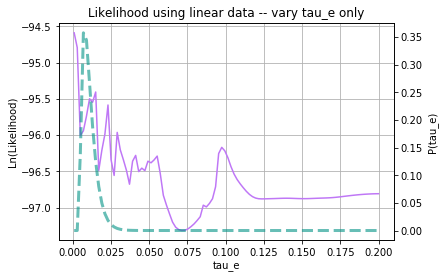

In [29]:
fig3, ax3a = mpl.subplots(figsize = (6,4))
mpl.plot(taue_run, trials, color = 'xkcd:light purple')

mpl.grid(True)
mpl.xlabel('tau_e')
mpl.ylabel('Ln(Likelihood)')
mpl.title('Likelihood using linear data -- vary tau_e only')
ax3b = ax3a.twinx()

fit_alpha_te = 2
fit_loc_te = 0.004492887509221829
fit_beta_te = 0.0032375996670863947
ytaue = (taue_run - fit_loc_te)/fit_beta_te
mpl.plot(taue_run, stats.gamma.pdf(ytaue, fit_alpha_te),'--', lw=3, alpha=0.6, label='gamma pdf', color = 'xkcd:teal')
mpl.ylabel('P(tau_e)')

fig3.savefig("Patient_8008_101_Likelihood_tauevaryonly.pdf", bbox_inches='tight')

As this is permitting only one parameter to vary, it is hard to say, but there is some suggestion that this means the allowed range of tau_e in the simulated annealling (0.005 - 0.02) could be missing the optimum. 

### Varying tau_i

In [ ]:
# params = parameters #start with the set of parameters from simulated annealing
# taui_run = np.linspace(0.001, 0.2, 100)
# trials = np.empty(len(taui_run)) 
# for i in range(len(taui_run)):
#     params['tau_i'] = taui_run[i]
#     trials[i] = ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

In [ ]:
# fig4, ax4a = mpl.subplots(figsize = (6,4))
# mpl.plot(taue_run, trials, color = 'xkcd:light purple')

# mpl.grid(True)
# mpl.xlabel('tau_i')
# mpl.ylabel('Ln(Likelihood)')
# mpl.title('Likelihood using linear data -- vary tau_i only')
# ax4b = ax4a.twinx()
# fit_alpha_ti = 2.006014687419703
# fit_loc_ti = 0.004662441067103153
# fit_beta_ti = 0.0025497764353055712
# ytaui = (taui_run - fit_loc_ti)/fit_beta_ti
# mpl.plot(taui_run, stats.gamma.pdf(ytaui, fit_alpha_ti),'--', lw=3, alpha=0.6, label='gamma pdf', color = 'xkcd:teal')
# mpl.ylabel('P(tau_i)')

# fig4.savefig("Patient_8008_101_Likelihood_tauivaryonly.pdf", bbox_inches='tight')

Again, there is some suggestion here that a local maximum might have been found, although it is challenging to be clear without allowing all parameters to vary. Allowed range in simulated annealing: 0.005- 0.02

### Varying tauC only

In [ ]:
params = parameters #start with the set of parameters from simulated annealing
tauC_run = np.linspace(0.001, 0.05, 100)
trials = np.empty(len(tauC_run)) 
for i in range(len(tauC_run)):
    params['tauC'] = tauC_run[i]
    trials[i] = ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

In [ ]:
fig5, ax5a = mpl.subplots(figsize = (6,4))
mpl.plot(tauC_run, trials, color = 'xkcd:light purple')

mpl.grid(True)
mpl.xlabel('tauC')
mpl.ylabel('Ln(Likelihood)')
mpl.title('Likelihood using linear data -- vary tauC only')
ax5b = ax5a.twinx()
fit_alpha_tc = 2 
fit_loc_tc = 0.00421181982183674
fit_beta_tc = 0.0029499360144432463
ytauc = (tauC_run - fit_loc_tc)/fit_beta_tc
mpl.plot(tauC_run, stats.gamma.pdf(ytauc, fit_alpha_tc),'--', lw=3, alpha=0.6, label='gamma pdf', color = 'xkcd:teal')
mpl.ylabel('P(tauC)')

fig4.savefig("Patient_8008_101_Likelihood_tauCvaryonly.pdf", bbox_inches='tight')

## Try running MCMC

This time, all I've done is slightly changed the likelihood function. Let's define the priors function (more) explicitly again.

In [ ]:
def lnprior_gamma(value, key, param_dists):
    tau = value
    x = (tau - param_dists[key]['loc'])/param_dists[key]['scale']
    p = stats.gamma.pdf(x, param_dists[key]['alpha'])
    p = p.astype(float)
    if p == 0:
        return -np.inf #use the same as for outside uniform distribution bounds
    return math.log(p)

In [ ]:
def lnprior_uniform(value, key, param_dists):
    if param_dists[key]['lower'] < value < param_dists[key]['upper']:
        p = stats.uniform.pdf(value, loc = param_dists[key]['lower'], scale = param_dists[key]['upper'])
        return math.log(p)
    return -np.inf

In [ ]:
def lnpriors(theta, param_dists):
    tau_e, tau_i, alpha, speed, gei, gii, tauC = theta
    
    lnp_taue = lnprior_gamma(tau_e, 'tau_e', param_dists)
    lnp_taui = lnprior_gamma(tau_i, 'tau_i', param_dists)
    lnp_alpha = lnprior_uniform(alpha, 'alpha', param_dists)
    lnp_speed = lnprior_uniform(speed, 'speed', param_dists)
    lnp_gei = lnprior_uniform(gei, 'gei', param_dists)
    lnp_gii = lnprior_uniform(gii, 'gii', param_dists)
    lnp_tauC = lnprior_gamma(tauC, 'tauC', param_dists)
    
    return lnp_taue + lnp_taui + lnp_alpha+lnp_speed+lnp_gei+lnp_gii+lnp_tauC

In [ ]:
def lnprobs(theta, param_dists, brain, fvec, data):
    print(theta)
    lnprior = lnpriors(theta, param_dists)
    if not np.isfinite(lnprior):
        return -np.inf
    return lnprior + ln_likelihood_pearson(theta, brain, fvec, data)

In [ ]:
import emcee

In [ ]:
pos = parameters

In [ ]:
ndim, nwalkers = 7, 16

Remember, we need to unfortunately import the parameters of the prior distributions by hand (to be improved).

In [ ]:
param_dists = {'tau_e':{'type':'gamma','alpha':2, 'loc':0.004492887509221829, 'scale':0.0032375996670863947},
    'tau_i':{'type':'gamma','alpha':2.006014687419703, 'loc':0.004662441067103153, 'scale':0.0025497764353055712},
              'alpha':{'type':'uniform','lower':0, 'upper':5},
              'speed':{'type':'uniform','lower':0, 'upper':25},
              'gei':{'type':'uniform','lower':0, 'upper':10},
              'gii':{'type':'uniform','lower':0, 'upper':10},
              'tauC':{'type':'gamma','alpha':2, 'loc':0.004211819821836749, 'scale':0.0029499360144432463}}

Just to make sure we have things in the correct format

In [ ]:
param_start_2 = []

for key, value in parameters.items():
    temp = [key,value]
    print(value.astype(float))
    param_start_2.append(value)

In [ ]:
param_start_2

In [ ]:
pos = [np.transpose(param_start_2) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] #starting position in parameter space.

In [ ]:
pos[:][0]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobs, args=(param_dists, newbrain, fvec,FMEGdownsample))

In [ ]:
sampler.run_mcmc(pos, 50);

In [ ]:
sampler.chain.shape

In [ ]:
time = np.arange(1,50)
len(time)

In [ ]:
time = np.arange(1,50)
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:49,0], linewidth = 0.1, color = 'black')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_e')

In [ ]:
for i in range(sampler.chain.shape[0]):
    mpl.plot(time, sampler.chain[i,:49,1], linewidth = 0.1, color = 'black')

ax3 = mpl.gca()
ax3.set_xlabel('step')
ax3.set_ylabel('tau_i')

This doesn't look too crazy so far, at least time it isn't running off to the boundary. But it needs running further.

TO DO:

- examine the likelihood function with the pearson cost again and make sure it is correct.
- make an alternative likelihood function based on single scaling and direct cost, and test that.